## Preprocessing
Before running this notebook, you should run `resource_download.ipynb` first to download the data.

Import the neccesary modules and set the path

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

VIDEO_TYPE = 'Low' # 'High' or 'Low'

Load the image

In [2]:
class IISFrames:
    
    def __init__(self, image_dir):
        image_path = Path(image_dir)
        self.image_names = [str(filename) for filename in image_path.glob('*.jpg')]
        self.image_names.sort()

        self.output_path = Path(f'videos/output-{VIDEO_TYPE}.mp4')
        self.output_path.parent.mkdir(parents=True, exist_ok=True)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # The high resolution video is too large to compile to a video.
        if VIDEO_TYPE == 'High':
            image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
            
        return image

    def __len__(self):
        return len(self.image_names)
    
    @property
    def export_resolution(self):
        shape = self[0].shape
        return shape[0], shape[1]

frames = IISFrames(image_dir=f'images/{VIDEO_TYPE}Res')
print(f'There are {len(frames)} frames in the video.')

There are 678 frames in the video.


Let's take a look the data we have

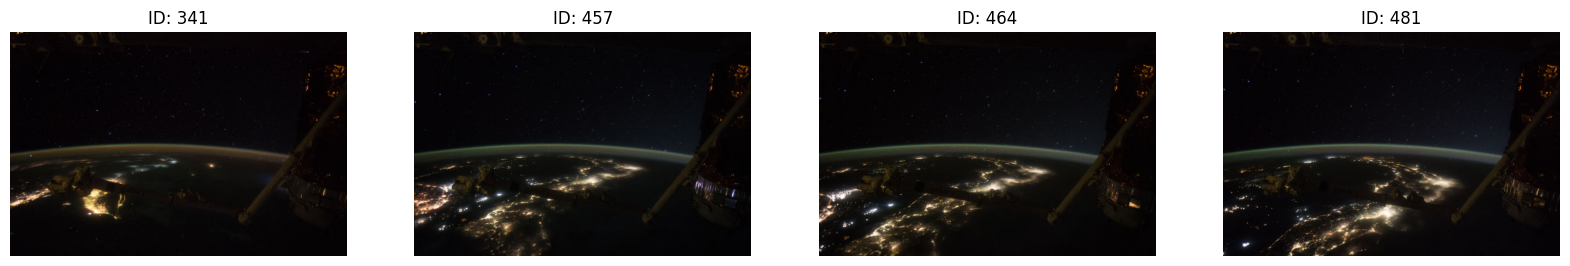

In [3]:
from random import randint

def show_examples(gallery=frames, num=4):

    # Generate num random indices and sort
    rands = [randint(0, len(gallery)) for _ in range(num)]
    rands.sort()

    # Plot the images
    fig, axs = plt.subplots(1, num, figsize=(20, 5))
    for i, r in enumerate(rands):
        axs[i].imshow(gallery[r])
        axs[i].set_title(f'ID: {r}')
        axs[i].axis('off')
    plt.show()

show_examples()

There are some images in this dataset is over exposure, we will drop them.

In [4]:
frames.image_names = frames.image_names[:-200]
print(f'There are {len(frames)} frames in the video.')

There are 478 frames in the video.


## Find the horizon belt

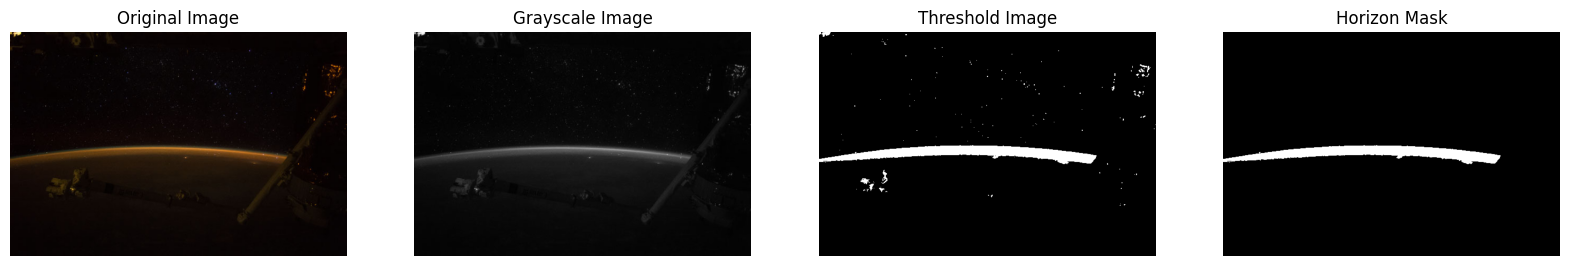

In [5]:
# Step.1 Read the first image
img = frames[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Step.2  Use threshold to find the brightest region
img_thres = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Step.3 Find the maximal region on the thresholded image
contours = cv2.findContours(img_thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
largest_id = np.argmax([cv2.contourArea(c) for c in contours])
largest_contour = contours[largest_id]

# Step.4 Draw the largest region on a blank image
img_horizon_mask = np.zeros_like(img_thres)
img_horizon_mask = cv2.drawContours(img_horizon_mask, [largest_contour], -1, 255, -1)
mask = (img_horizon_mask > 0).astype(np.uint8)
mask_inv = (img_horizon_mask == 0).astype(np.uint8)

# Step.5 visualize the results
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    axs[i].axis('off')

axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(img_gray, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[2].imshow(img_thres, cmap='gray')
axs[2].set_title('Threshold Image')
axs[3].imshow(img_horizon_mask, cmap='gray')
axs[3].set_title('Horizon Mask')
plt.show()


## Find the star

  0%|          | 0/478 [00:00<?, ?it/s]

100%|██████████| 478/478 [00:01<00:00, 292.58it/s]


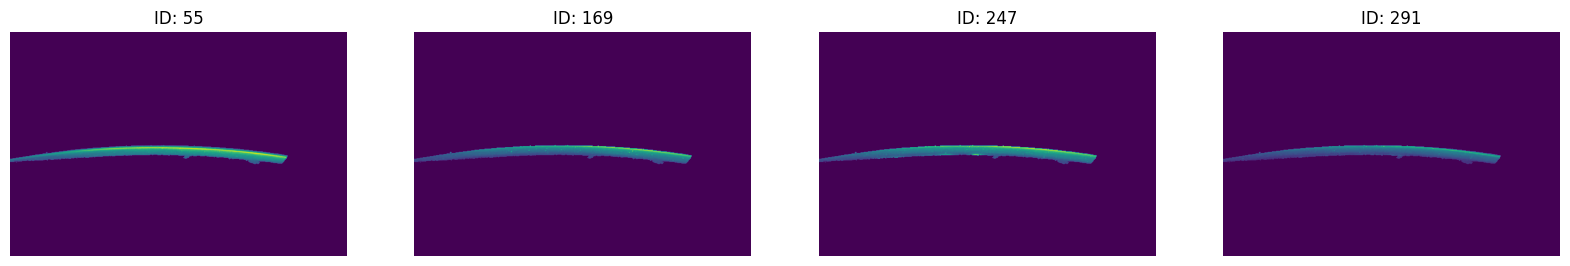

In [6]:
def crop_horizon_frame(img: np.ndarray, mask: np.ndarray):
    img_masked = img.copy()
    img_masked = cv2.bitwise_and(img_masked, img_masked, mask=mask)
    img_masked = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
    return img_masked

horizon_frames = [ crop_horizon_frame(frame, mask) for frame in tqdm(frames) ]
show_examples(gallery=horizon_frames)


  0%|          | 0/478 [00:00<?, ?it/s]

100%|██████████| 478/478 [00:05<00:00, 81.65it/s]


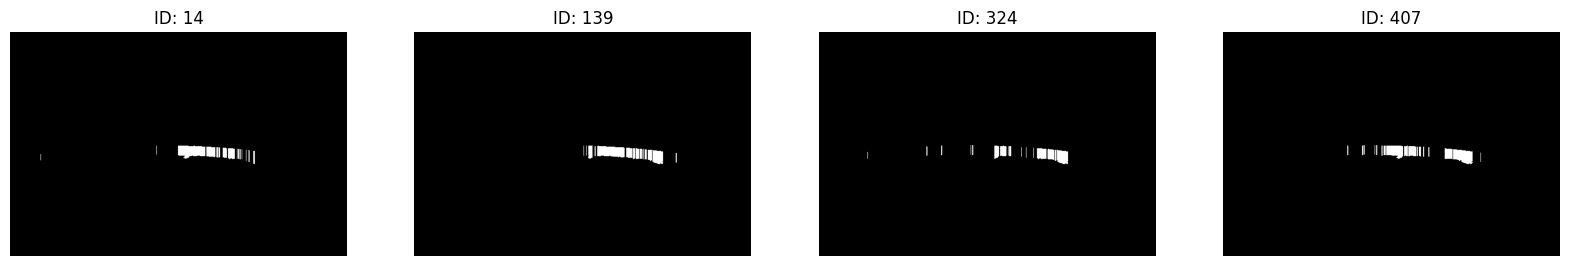

In [19]:
def star_spectrum(img: np.ndarray, mask: np.ndarray):

    col_std = lambda x: np.std(x) if x.shape[0] > 0 else 0
    stds = np.array([col_std(col[np.nonzero(col)]) for col in img.T])
    stds = (stds - stds.mean()) / (stds.std() + 1e-5) >= 1
    stds = (stds*255).astype(np.uint8)

    frame = stds[np.newaxis, ..., np.newaxis]
    frame = np.tile(frame, [img.shape[0],1,3]) # repeat the channel 3 times
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)
    return masked_frame

star_spectrum_frames = [ star_spectrum(frame, mask) for frame in tqdm(horizon_frames) ]
show_examples(gallery=star_spectrum_frames)

## Export the video

In [18]:
# create the video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_h, frame_w = frames.export_resolution

# write each image to the video
video_writer = cv2.VideoWriter(str(frames.output_path), fourcc, 15, (frame_w, frame_h))

for i in tqdm(range(len(frames)), desc='Rendering video'):
    
    frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)
    frame_ad = adjusted_frames[i]

    frame = cv2.bitwise_and(frame, frame, mask=mask_inv)
    frame = cv2.add(frame, frame_ad)
    video_writer.write(frame)

# release the video writer object
video_writer.release()


Rendering video:   0%|          | 0/478 [00:00<?, ?it/s]

Rendering video: 100%|██████████| 478/478 [00:02<00:00, 201.01it/s]
